#### Задание
Предлагается  предаггрегированные данные по пользователям 
Cust_id – идентификатор пользователя
Source – утм-метки пользователя 
Orders – кол-во заказов пользователя 
LTV – Life time value:  сколько принес пользователь за весь период жизни на платформе 

1.  Для каждой строки требуется вычленить source, medium, campaign пользователя 
2.  Посчитайте средний LTV на пользователя,  и среднее кол-во заказов  сравните поканально (source). Есть ли значимые различия? 
3.  Какой из каналов на ваш взгляд более эффективно работает 
4.  Можно ли оптимизировать каждый из каналов? 

Предложите и посчитайте ещё 2-3 показателя, характеризующих качество групп привлекаемой аудитории. Проанализируйте полученные результаты и опишите суть различий между группами.
Расчётную часть задачи выполните на  Python.
К заданию приложите ваш скрипт и краткий отчёт, включающий анализ и выводы.

<a id ="nachalo"> </a>
### Вычисления.
### или можно сразу  [перейти к выводам с картинками](#summary)

In [1]:
# утнановка pandas_profiling: pip install pandas-profiling
import numpy as np
import pandas as pd
from urllib.parse import urlsplit, parse_qs
import matplotlib.pyplot as plt
import pandas_profiling

## 1.
###### Для каждой строки требуется вычленить source, medium, campaign пользователя

#### цсв -> датафрейм

In [2]:
df = pd.read_csv('/Users/s.novozhilov/Downloads/data_test_mktg_anlst.csv', delimiter=';')
df.head(2)

,cust_id,source,orders,ltv
0,859,?utm_source=google&utm_medium=cpc&utm_campaign...,28,913
1,232,?utm_source=google&utm_medium=cpc&utm_campaign...,18,3157


#### Парсим метки, кладем в df

In [3]:
def parse_utm(row, utm_name):
    query_string = urlsplit(row["source"]).query
    utm = parse_qs(query_string)
    return utm[utm_name][0]

In [4]:
df["utm_source"] = df.apply(parse_utm, axis = 1, utm_name = "utm_source")
df["utm_medium"] = df.apply(parse_utm, axis = 1, utm_name = "utm_medium")
df["utm_campaign"] = df.apply(parse_utm, axis = 1, utm_name = "utm_campaign")

In [5]:
df.head(3)

,cust_id,source,orders,ltv,utm_source,utm_medium,utm_campaign
0,859,?utm_source=google&utm_medium=cpc&utm_campaign...,28,913,google,cpc,demographic_targets_male_age25-34
1,232,?utm_source=google&utm_medium=cpc&utm_campaign...,18,3157,google,cpc,demographic_targets_female_age18-24
2,2523,?utm_source=mytarget&utm_medium=cpc&utm_campai...,1,1208,mytarget,cpc,demographic_targets_male_age25-34


####  Дополнительно вытащим пол и возраст

In [6]:
def demographic_parse(row, utm, feature):
    return row[utm].split('_')[feature]
df["sex"] = df.apply(demographic_parse, axis=1, utm="utm_campaign", feature=2)
df["age"] = df.apply(demographic_parse, axis=1, utm="utm_campaign", feature=3)

In [7]:
#удаляем изначальные метки, чтобы не мешались
df.drop(['source'], axis='columns', inplace=True)

In [8]:
# подготовленные данные
df.head(3)

,cust_id,orders,ltv,utm_source,utm_medium,utm_campaign,sex,age
0,859,28,913,google,cpc,demographic_targets_male_age25-34,male,age25-34
1,232,18,3157,google,cpc,demographic_targets_female_age18-24,female,age18-24
2,2523,1,1208,mytarget,cpc,demographic_targets_male_age25-34,male,age25-34


## 2.
##### Посчитайте средний LTV на пользователя, и среднее кол-во заказов сравните поканально (source). Есть ли значимые различия?

#### быстрая (но информативная) разведка данных

In [9]:
pandas_profiling.ProfileReport(df)

В данных пользователи уникальны. -> средний LTV на пользователя = средний LTV = **405.2**  
среднее кол-во заказов = **30.6**  
Распределения не перекошены, медианные значения LTV и заказов на уровне средних.

У юзеров из каналов "facebook", "google" и "mytarget" среднее LTV **360**, **463** и **409** соответственно.

Среднее кол-во заказов в каналах "google" и "mytarget" на одном уровне - 32,3 и 32,9. А вот из "facebook" делают в среднем на 7 заказов меньше (25,5).

Лучшие средние метрики у пользователей из канала "google", но канал привлек всего 1000 пользователей (20%).  
Хуже других выглядят метрики пользователей из "facebook" - заказы на пальзователя и LTV ниже средних (на 15% и 10% соответственно).

,cust_count,avg_orders,avg_ltv
utm_source,,,
facebook,1501,25.5,359.5
google,1000,32.3,463.3
mytarget,2499,32.9,409.4


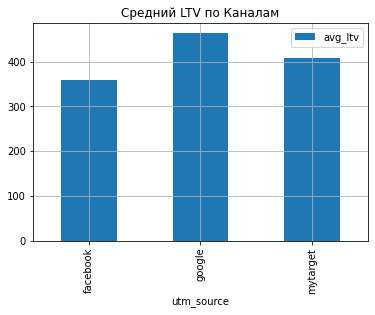

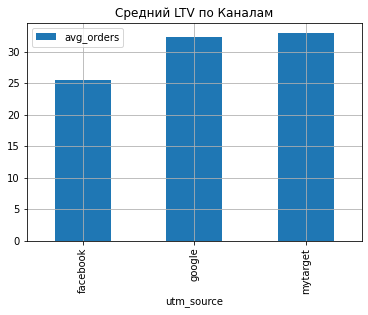

In [10]:
#Средний LTV по Каналам
source_agg = df.groupby(by="utm_source").agg(cust_count = ('cust_id', 'count'),
         avg_orders = ('orders', 'mean'),
         avg_ltv = ('ltv', 'mean'),
         sum_orders = ('orders', 'sum'),
         sum_ltv = ('ltv', 'sum'),
        )
#график
source_agg.plot.bar(y="avg_ltv", grid = True, title = "Средний LTV по Каналам")
source_agg.plot.bar(y="avg_orders", grid = True, title = "Средний LTV по Каналам")
source_agg.iloc[:, 0:3].round(1)


## 3.
##### Какой из каналов на ваш взгляд более эффективно работает

Чтобы понять, какой канал наиболее эффективно работает, я предлагаю опираться не на средние метрики а на суммарные.

Из канала "mytarget" пришло 50% клиентов - столько же, сколько из "google" и "facebook" вместе взятых.  
Суммарное количество заказов (82286) и суммарный LTV (1023034) составили больше остальных каналов вместе.

Не смотря на то, что средний LTV у пользователей из "google" чуть лучше, "mytarget" - самый эффективный канал.

In [11]:
source_agg.iloc[:, 3:5]

,sum_orders,sum_ltv
utm_source,,
facebook,38300,539647
google,32303,463286
mytarget,82286,1023034


array([<AxesSubplot:ylabel='sum_orders'>, <AxesSubplot:ylabel='sum_ltv'>],
      dtype=object)

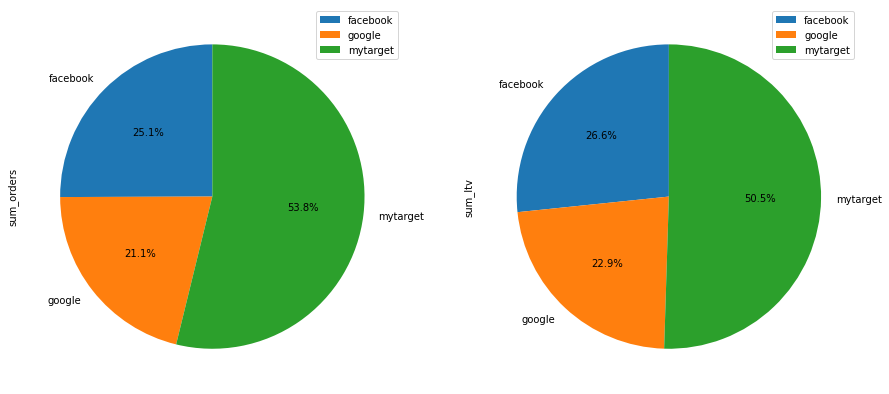

In [12]:
(source_agg.iloc[:, 3:5]
     .plot.pie(subplots=True, figsize=(15, 15),autopct="%.1f%%", startangle=90))

## 4.
##### Можно ли оптимизировать каждый из каналов?

Как мы помним, у юзеров из "google" LTV больше, чем в других каналах (и больше среднего на 58 руб.) -> можем предположить, что повышение ставки***** для этого канала (модель utm_medium=cpc для всех) позволит привликать больше самых прибыльных клиентов.

Но сначала проверим, нет ли специфики таргетов среди каналов, возможно мы сможем более точно настроить цены.  
Посмотрим распределение таргетов по полу и возрасту в рамках каналов.
№№№траблички про пол и про возраст


* **Канал "google"**
Самые высокие средние заказы и LTV, отдинаково распределены между обоими полами -> в "google" стоит повысить ставки для обоих полов.  
Для всех возрастных групп в этом канале заказы и LTV так же выше средних -> стоит повысить ставки для всех возрастов, особенно для группы age18-24 - в ней самый высокий LTV среди всех возможных.

* **Канал "mytarget"**
В "mytarget" таргет на мужчин привликает более выгодных клиентов, чем таргет на женщин (LTV 430 против LTV 394) -> для мужчин надо повысить ставку.  
В возрастной группе age35 LTV больше средного (на 10%) -> ставку повышаем.  
А вот в группе age18-24 средний LTV на 12% меньше среднего LTV по выборке -> ставку понижаем

* **Канал "facebook"**
В группе age35 LTV немного выше среднего (на 5%) -> эту ставку не понижаем  
В остальных группах половозрастных таргетов канала "facebook" привлекаются не такие выгодные пользователи, как в других каналах -> надо понизить ставки для этих групп (за счет понижений финансируем повышения других групп).*

Цель изменения ставок - повысить суммарный LTV всех пользователей, привлекая лучших клиентов.  
Рассматриваю отдельно аггрегации по полу и возрасту, не рассматриваю аггрегацию по utm_campaign тк слишко мало клиентов для рассуждении  

***** *ставка = ставка или цена клика, или закупаемый объема.*

In [13]:
source_agg.iloc[:, 3:5]

,sum_orders,sum_ltv
utm_source,,
facebook,38300,539647
google,32303,463286
mytarget,82286,1023034


In [14]:
#Пол по каналам
sex_agg = (df.groupby(by=["utm_source", "sex"]).agg(cust_count = ('cust_id', 'count'),
         avg_orders = ('orders', 'mean'),
         avg_ltv = ('ltv', 'mean')
        ))

In [15]:
(sex_agg.round(0)
    .style
    .format("{:.0f}")
    .background_gradient(cmap='PuBu', axis=0))

In [16]:
#Возраст по каналам
age_agg = (df.groupby(by=["utm_source", "age"]).agg(cust_count = ('cust_id', 'count'),
         avg_orders = ('orders', 'mean'),
         avg_ltv = ('ltv', 'mean')
        ))

In [17]:
(age_agg.round(0)
    .style
    .format("{:.0f}")
    .background_gradient(cmap='PuBu', axis=0))

In [18]:
#аггрегация по utm_campaign (пол+возраст) на всякий случай

In [19]:
#Возраст по каналам
sex_age_agg = (df.groupby(by=["utm_source","sex", "age"]).agg(cust_count = ('cust_id', 'count'),
         avg_orders = ('orders', 'mean'),
         avg_ltv = ('ltv', 'mean')
        ))

In [20]:
(sex_age_agg.round(0)
    .style
    .format("{:.0f}")
    .background_gradient(cmap='PuBu', axis=0))

<AxesSubplot:ylabel='Frequency'>

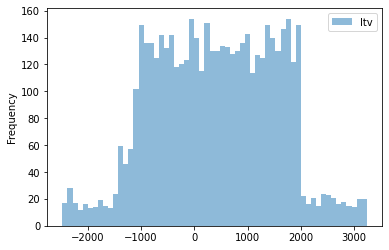

In [21]:
df.iloc[:, 2:3].plot.hist(bins=60, alpha=0.5)

 всё.

<a id='summary'></a>
### Только Выводы

**2.** В данных пользователи уникальны. -> средний LTV на пользователя = средний LTV = **405,2**  
среднее кол-во заказов = **30,6**  
Распределения не перекошены, медианные значения LTV и заказов на уровне средних.

У юзеров из каналов "facebook", "google" и "mytarget" среднее LTV **360**, **463** и **409** соответственно.

Среднее кол-во заказов в каналах "google" и "mytarget" на одном уровне - 32,3 и 32,9. А вот из "facebook" делают в среднем на 7 заказов меньше (25,5)

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>cust_count</th>
      <th>avg_orders</th>
      <th>avg_ltv</th>
    </tr>
    <tr>
      <th>utm_source</th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>facebook</th>
      <td>1501</td>
      <td>25.5</td>
      <td>359.5</td>
    </tr>
    <tr>
      <th>google</th>
      <td>1000</td>
      <td>32.3</td>
      <td>463.3</td>
    </tr>
    <tr>
      <th>mytarget</th>
      <td>2499</td>
      <td>32.9</td>
      <td>409.4</td>
    </tr>
  </tbody>
</table>
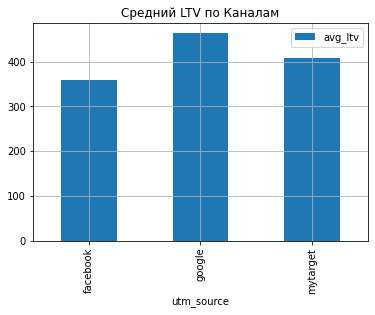

Лучшие средние метрики у пользователей из канала "google", но канал привлек всего 1000 пользователей (20%)  
Хуже других выглядят метрики пользователей из "facebook" - заказы на пальзователя и LTV ниже средних (на 15% и 10% соответственно).

**3.** Чтобы понять, какой канал наиболее эффективно работает, я предлагаю опираться не на средние метрики а на суммарные.

Из канала "mytarget" пришло 50% клиентов - столько же, сколько из "google" и "facebook" вместе взятых.  
Суммарное количество заказов (82286) и суммарный LTV (1023034) так же составили больше остальных каналов вместе.

Не смотря на то, что средний LTV у пользователей из "google" чуть лучше, "mytarget" - самый эффективный канал.
<img src="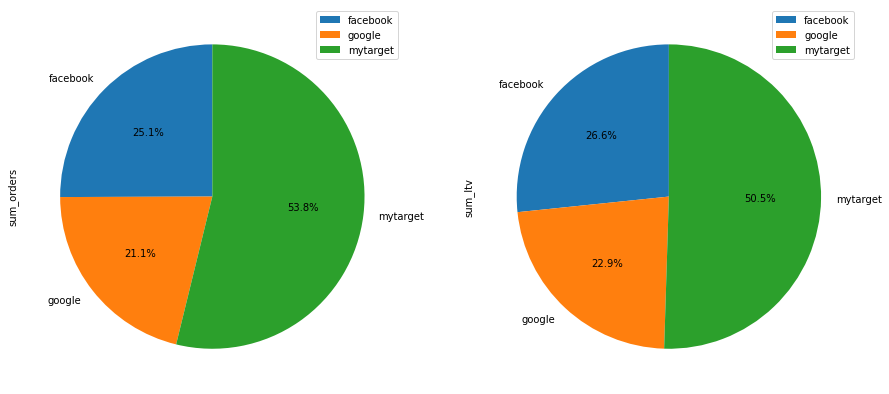
">


**4.** Как мы помним, у юзеров из "google" LTV больше, чем в других каналах (и больше среднего на 58 руб.) ->  
Можем предположить, что повышение ставки***** для этого канала (модель utm_medium=cpc для всех) позволит привликать больше самых прибыльных клиентов.

Но сначала проверим, нет ли специфики таргетов среди каналов, возможно мы сможем более точно настроить цены.  
Посмотрим распределение таргетов по полу и возрасту в рамках каналов.

***** *ставка = ставка или цена клика, или закупаемый объема.*

<div class="output_subarea output_html rendered_html output_result"><style type="text/css">
#T_8316048a_2c14_11eb_a6f2_f018981ed8aerow0_col0{
            background-color:  #d3d4e7;
            color:  #000000;
        }#T_8316048a_2c14_11eb_a6f2_f018981ed8aerow0_col1{
            background-color:  #ece7f2;
            color:  #000000;
        }#T_8316048a_2c14_11eb_a6f2_f018981ed8aerow0_col2,#T_8316048a_2c14_11eb_a6f2_f018981ed8aerow1_col1,#T_8316048a_2c14_11eb_a6f2_f018981ed8aerow2_col0{
            background-color:  #fff7fb;
            color:  #000000;
        }#T_8316048a_2c14_11eb_a6f2_f018981ed8aerow1_col0,#T_8316048a_2c14_11eb_a6f2_f018981ed8aerow4_col2{
            background-color:  #b3c3de;
            color:  #000000;
        }#T_8316048a_2c14_11eb_a6f2_f018981ed8aerow1_col2{
            background-color:  #f3edf5;
            color:  #000000;
        }#T_8316048a_2c14_11eb_a6f2_f018981ed8aerow2_col1,#T_8316048a_2c14_11eb_a6f2_f018981ed8aerow2_col2,#T_8316048a_2c14_11eb_a6f2_f018981ed8aerow4_col0,#T_8316048a_2c14_11eb_a6f2_f018981ed8aerow4_col1,#T_8316048a_2c14_11eb_a6f2_f018981ed8aerow5_col1{
            background-color:  #023858;
            color:  #f1f1f1;
        }#T_8316048a_2c14_11eb_a6f2_f018981ed8aerow3_col0{
            background-color:  #f6eff7;
            color:  #000000;
        }#T_8316048a_2c14_11eb_a6f2_f018981ed8aerow3_col1{
            background-color:  #04598c;
            color:  #f1f1f1;
        }#T_8316048a_2c14_11eb_a6f2_f018981ed8aerow3_col2{
            background-color:  #045687;
            color:  #f1f1f1;
        }#T_8316048a_2c14_11eb_a6f2_f018981ed8aerow5_col0{
            background-color:  #4295c3;
            color:  #000000;
        }#T_8316048a_2c14_11eb_a6f2_f018981ed8aerow5_col2{
            background-color:  #2c89bd;
            color:  #000000;
        }</style><table id="T_8316048a_2c14_11eb_a6f2_f018981ed8ae"><thead>    <tr>        <th class="blank"></th>        <th class="blank level0"></th>        <th class="col_heading level0 col0">cust_count</th>        <th class="col_heading level0 col1">avg_orders</th>        <th class="col_heading level0 col2">avg_ltv</th>    </tr>    <tr>        <th class="index_name level0">utm_source</th>        <th class="index_name level1">sex</th>        <th class="blank"></th>        <th class="blank"></th>        <th class="blank"></th>    </tr></thead><tbody>
                <tr>
                        <th id="T_8316048a_2c14_11eb_a6f2_f018981ed8aelevel0_row0" class="row_heading level0 row0" rowspan="2">facebook</th>
                        <th id="T_8316048a_2c14_11eb_a6f2_f018981ed8aelevel1_row0" class="row_heading level1 row0">female</th>
                        <td id="T_8316048a_2c14_11eb_a6f2_f018981ed8aerow0_col0" class="data row0 col0">700</td>
                        <td id="T_8316048a_2c14_11eb_a6f2_f018981ed8aerow0_col1" class="data row0 col1">26</td>
                        <td id="T_8316048a_2c14_11eb_a6f2_f018981ed8aerow0_col2" class="data row0 col2">355</td>
            </tr>
            <tr>
                                <th id="T_8316048a_2c14_11eb_a6f2_f018981ed8aelevel1_row1" class="row_heading level1 row1">male</th>
                        <td id="T_8316048a_2c14_11eb_a6f2_f018981ed8aerow1_col0" class="data row1 col0">801</td>
                        <td id="T_8316048a_2c14_11eb_a6f2_f018981ed8aerow1_col1" class="data row1 col1">25</td>
                        <td id="T_8316048a_2c14_11eb_a6f2_f018981ed8aerow1_col2" class="data row1 col2">364</td>
            </tr>
            <tr>
                        <th id="T_8316048a_2c14_11eb_a6f2_f018981ed8aelevel0_row2" class="row_heading level0 row2" rowspan="2">google</th>
                        <th id="T_8316048a_2c14_11eb_a6f2_f018981ed8aelevel1_row2" class="row_heading level1 row2">female</th>
                        <td id="T_8316048a_2c14_11eb_a6f2_f018981ed8aerow2_col0" class="data row2 col0">471</td>
                        <td id="T_8316048a_2c14_11eb_a6f2_f018981ed8aerow2_col1" class="data row2 col1">33</td>
                        <td id="T_8316048a_2c14_11eb_a6f2_f018981ed8aerow2_col2" class="data row2 col2">470</td>
            </tr>
            <tr>
                                <th id="T_8316048a_2c14_11eb_a6f2_f018981ed8aelevel1_row3" class="row_heading level1 row3">male</th>
                        <td id="T_8316048a_2c14_11eb_a6f2_f018981ed8aerow3_col0" class="data row3 col0">529</td>
                        <td id="T_8316048a_2c14_11eb_a6f2_f018981ed8aerow3_col1" class="data row3 col1">32</td>
                        <td id="T_8316048a_2c14_11eb_a6f2_f018981ed8aerow3_col2" class="data row3 col2">457</td>
            </tr>
            <tr>
                        <th id="T_8316048a_2c14_11eb_a6f2_f018981ed8aelevel0_row4" class="row_heading level0 row4" rowspan="2">mytarget</th>
                        <th id="T_8316048a_2c14_11eb_a6f2_f018981ed8aelevel1_row4" class="row_heading level1 row4">female</th>
                        <td id="T_8316048a_2c14_11eb_a6f2_f018981ed8aerow4_col0" class="data row4 col0">1444</td>
                        <td id="T_8316048a_2c14_11eb_a6f2_f018981ed8aerow4_col1" class="data row4 col1">33</td>
                        <td id="T_8316048a_2c14_11eb_a6f2_f018981ed8aerow4_col2" class="data row4 col2">394</td>
            </tr>
            <tr>
                                <th id="T_8316048a_2c14_11eb_a6f2_f018981ed8aelevel1_row5" class="row_heading level1 row5">male</th>
                        <td id="T_8316048a_2c14_11eb_a6f2_f018981ed8aerow5_col0" class="data row5 col0">1055</td>
                        <td id="T_8316048a_2c14_11eb_a6f2_f018981ed8aerow5_col1" class="data row5 col1">33</td>
                        <td id="T_8316048a_2c14_11eb_a6f2_f018981ed8aerow5_col2" class="data row5 col2">430</td>
            </tr>
    </tbody></table></div>
    
<table id="T_83244202_2c14_11eb_a6f2_f018981ed8ae"><thead>    <tr>        <th class="blank"></th>        <th class="blank level0"></th>        <th class="col_heading level0 col0">cust_count</th>        <th class="col_heading level0 col1">avg_orders</th>        <th class="col_heading level0 col2">avg_ltv</th>    </tr>    <tr>        <th class="index_name level0">utm_source</th>        <th class="index_name level1">age</th>        <th class="blank"></th>        <th class="blank"></th>        <th class="blank"></th>    </tr></thead><tbody>
                <tr>
                        <th id="T_83244202_2c14_11eb_a6f2_f018981ed8aelevel0_row0" class="row_heading level0 row0" rowspan="3">facebook</th>
                        <th id="T_83244202_2c14_11eb_a6f2_f018981ed8aelevel1_row0" class="row_heading level1 row0">age18-24</th>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow0_col0" class="data row0 col0">445</td>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow0_col1" class="data row0 col1">26</td>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow0_col2" class="data row0 col2">322</td>
            </tr>
            <tr>
                                <th id="T_83244202_2c14_11eb_a6f2_f018981ed8aelevel1_row1" class="row_heading level1 row1">age25-34</th>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow1_col0" class="data row1 col0">671</td>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow1_col1" class="data row1 col1">25</td>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow1_col2" class="data row1 col2">349</td>
            </tr>
            <tr>
                                <th id="T_83244202_2c14_11eb_a6f2_f018981ed8aelevel1_row2" class="row_heading level1 row2">age35 </th>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow2_col0" class="data row2 col0">385</td>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow2_col1" class="data row2 col1">25</td>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow2_col2" class="data row2 col2">421</td>
            </tr>
            <tr>
                        <th id="T_83244202_2c14_11eb_a6f2_f018981ed8aelevel0_row3" class="row_heading level0 row3" rowspan="3">google</th>
                        <th id="T_83244202_2c14_11eb_a6f2_f018981ed8aelevel1_row3" class="row_heading level1 row3">age18-24</th>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow3_col0" class="data row3 col0">322</td>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow3_col1" class="data row3 col1">33</td>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow3_col2" class="data row3 col2">508</td>
            </tr>
            <tr>
                                <th id="T_83244202_2c14_11eb_a6f2_f018981ed8aelevel1_row4" class="row_heading level1 row4">age25-34</th>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow4_col0" class="data row4 col0">383</td>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow4_col1" class="data row4 col1">31</td>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow4_col2" class="data row4 col2">458</td>
            </tr>
            <tr>
                                <th id="T_83244202_2c14_11eb_a6f2_f018981ed8aelevel1_row5" class="row_heading level1 row5">age35 </th>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow5_col0" class="data row5 col0">295</td>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow5_col1" class="data row5 col1">33</td>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow5_col2" class="data row5 col2">421</td>
            </tr>
            <tr>
                        <th id="T_83244202_2c14_11eb_a6f2_f018981ed8aelevel0_row6" class="row_heading level0 row6" rowspan="3">mytarget</th>
                        <th id="T_83244202_2c14_11eb_a6f2_f018981ed8aelevel1_row6" class="row_heading level1 row6">age18-24</th>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow6_col0" class="data row6 col0">833</td>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow6_col1" class="data row6 col1">33</td>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow6_col2" class="data row6 col2">358</td>
            </tr>
            <tr>
                                <th id="T_83244202_2c14_11eb_a6f2_f018981ed8aelevel1_row7" class="row_heading level1 row7">age25-34</th>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow7_col0" class="data row7 col0">1065</td>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow7_col1" class="data row7 col1">33</td>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow7_col2" class="data row7 col2">428</td>
            </tr>
            <tr>
                                <th id="T_83244202_2c14_11eb_a6f2_f018981ed8aelevel1_row8" class="row_heading level1 row8">age35 </th>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow8_col0" class="data row8 col0">601</td>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow8_col1" class="data row8 col1">32</td>
                        <td id="T_83244202_2c14_11eb_a6f2_f018981ed8aerow8_col2" class="data row8 col2">447</td>
            </tr>
    </tbody></table>

* **Канал "google"**
Самые высокие средние заказы и LTV, отдинаково распределены между обоими полами -> в "google" стоит повысить ставки для обоих полов.  
Для всех возрастных групп в этом канале заказы и LTV так же выше средних -> стоит повысить ставки для всех возрастов, особенно для группы age18-24 - в ней самый высокий LTV среди всех возможных.

* **Канал "mytarget"**
В "mytarget" таргет на мужчин привликает более выгодных клиентов, чем таргет на женщин (LTV 430 против LTV 394) -> для мужчин надо повысить ставку.  
В возрастной группе age35 LTV больше средного (на 10%) -> ставку повышаем.  
А вот в группе age18-24 средний LTV на 12% меньше среднего LTV по выборке -> ставку понижаем

* **Канал "facebook"**
В группе age35 LTV немного выше среднего (на 5%) -> эту ставку не понижаем  
В остальных группах половозрастных таргетов канала "facebook" привлекаются не такие выгодные пользователи, как в других каналах -> надо понизить ставки для этих групп (за счет понижений финансируем повышения других групп).*

Цель изменения ставок - повысить суммарный LTV всех пользователей, привлекая лучших клиентов.  
Рассматриваем отдельно аггрегации по полу и по возрасту, а не аггрегацию по utm_campaign тк в образованных группах часто слишком мало клиентов для вывода.

#### [назад к расчетам](#nachalo)